In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer  # Changed to CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import gensim
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/processed_train_data.csv")

# Assuming dataset has 'Text' and 'Label' columns
texts = data['Text'].astype(str).values
labels = data['Label'].values

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenization for Word2Vec
vocab_size = 10000  # Vocabulary size
max_length = 100    # Maximum sequence length
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Train Word2Vec model on your dataset using Gensim
# Tokenize the text data into words
tokenized_texts = [text.split() for text in texts]

# Create a Word2Vec model using the tokenized texts
word2vec_model = gensim.models.Word2Vec(
    tokenized_texts, vector_size=300, window=5, min_count=1, workers=4
)

# Prepare the embedding matrix for Word2Vec
embedding_dim = 300  # Word2Vec embedding dimension
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[index] = embedding_vector
        except KeyError:
            pass  # Word not in Word2Vec vocabulary

# Create CountVectorizer
count_vectorizer = CountVectorizer(max_features=10000)  # You can adjust the number of features
X_train_count = count_vectorizer.fit_transform(X_train).toarray()  # Using CountVectorizer instead of TF-IDF
X_test_count = count_vectorizer.transform(X_test).toarray()  # Using CountVectorizer instead of TF-IDF

# Build the model
input_text = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_text)
bidirectional_gru = Bidirectional(GRU(64, return_sequences=False))(embedding_layer)
dropout_1 = Dropout(0.5)(bidirectional_gru)

# Concatenate Word2Vec features with Count Vectorizer features
input_count = Input(shape=(X_train_count.shape[1],))  # Shape of the CountVectorizer features
concat = Concatenate()([dropout_1, input_count])

dense_1 = Dense(64, activation='relu')(concat)
dropout_2 = Dropout(0.5)(dense_1)
output = Dense(len(np.unique(y_train)), activation='softmax')(dropout_2)

# Define the model
model = Model(inputs=[input_text, input_count], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_pad, X_train_count], y_train,
    epochs=10, batch_size=32,
    validation_data=([X_test_pad, X_test_count], y_test)
)

# Evaluate the model on train and test data


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.2506 - loss: 1.5914 - val_accuracy: 0.6700 - val_loss: 1.4107
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.6179 - loss: 1.3312 - val_accuracy: 0.7833 - val_loss: 1.1096
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 529ms/step - accuracy: 0.7397 - loss: 1.0495 - val_accuracy: 0.8670 - val_loss: 0.8267
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.8017 - loss: 0.7882 - val_accuracy: 0.9089 - val_loss: 0.6318
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - accuracy: 0.8420 - loss: 0.6286 - val_accuracy: 0.9310 - val_loss: 0.5004
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.8994 - loss: 0.4617 - val_accuracy: 0.9360 - val_loss: 0.4021
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9153 - loss: 0.4010 - val_accuracy: 0.9483 - val_loss: 0.3393
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.9469 - loss: 0.2974 - val_accu

Train Accuracy: 0.9865, Train Loss: 0.1333
Test Accuracy: 0.9458, Test Loss: 0.2367


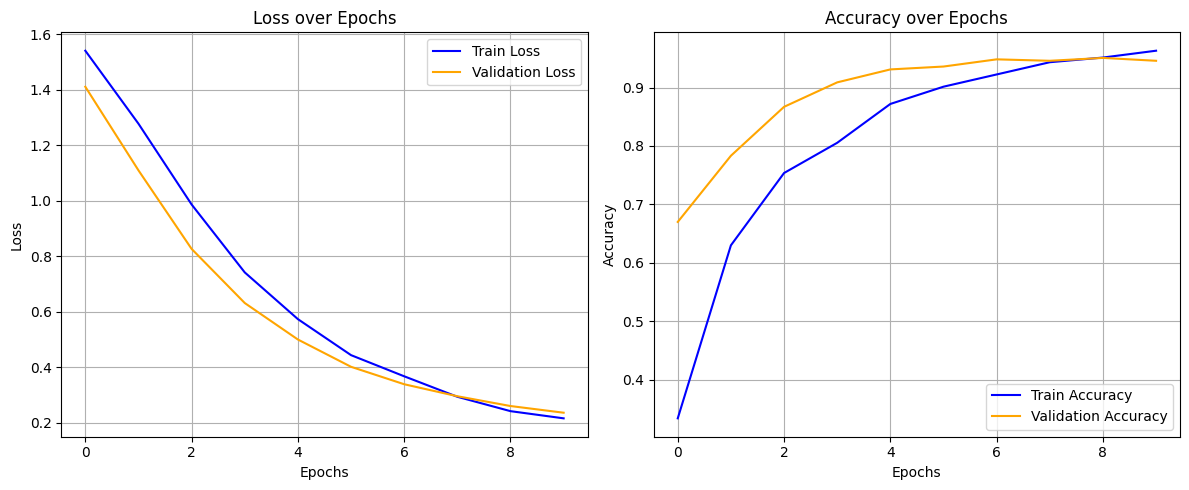

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step

Classification Report:

              precision    recall  f1-score   support

           C       0.95      0.91      0.93        81
           G       0.92      0.98      0.95        81
           N       0.90      0.91      0.91        81
           P       0.97      0.94      0.96        82
           R       0.99      0.99      0.99        81

    accuracy                           0.95       406
   macro avg       0.95      0.95      0.95       406
weighted avg       0.95      0.95      0.95       406



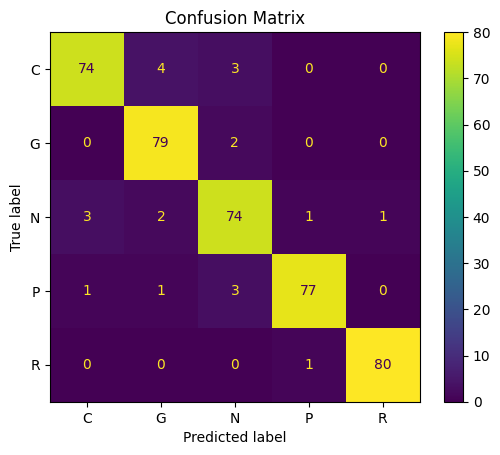

Macro Precision: 0.9464
Macro Recall: 0.9458
Macro F1 Score: 0.9458


<ipython-input-6-1b82bc4555f5>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


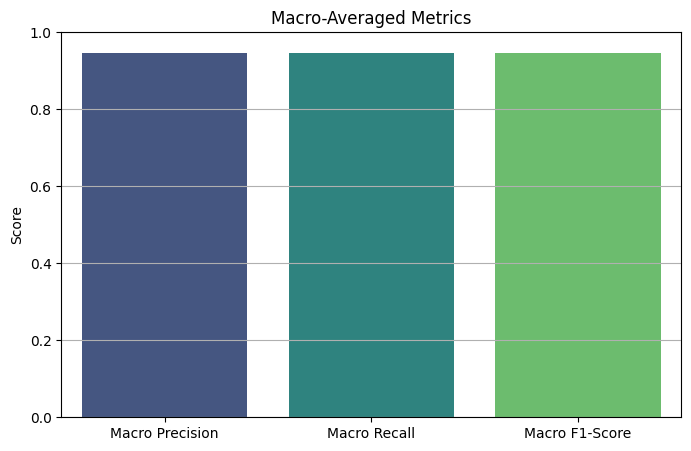

In [6]:
import seaborn as sns
train_loss, train_acc = model.evaluate([X_train_pad, X_train_count], y_train, verbose=0)
test_loss, test_acc = model.evaluate([X_test_pad, X_test_count], y_test, verbose=0)
print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Predictions on the test set
y_pred = model.predict([X_test_pad, X_test_count])
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# Macro-Averaged Metrics (Precision, Recall, F1-Score)
macro_precision, macro_recall, macro_f1_r, _ = precision_recall_fscore_support(
    y_test, y_pred_labels, average="macro"
)

# Print Macro F1 Score
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1_r:.4f}")

# Plot Macro-Averaged Metrics
metrics = ["Macro Precision", "Macro Recall", "Macro F1-Score"]
values = [macro_precision, macro_recall, macro_f1_r]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.title("Macro-Averaged Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()

# Path to the test data (CSV file)



In [7]:
test_file_path = '/content/drive/MyDrive/processed_test_data.csv'

# Read test data
test_data = pd.read_csv(test_file_path)

# Assuming 'Transcript' is the column with the input text
X_test_text = test_data['Transcript'].astype(str).values

# Preprocess test data with CountVectorizer
X_test_count = count_vectorizer.transform(X_test_text)

# Tokenize the test text
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad the sequences (ensure same length as training data)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Ensure the model can handle both the padded sequences and Count Vectorizer features.
X_test_combined = [X_test_pad, X_test_count.toarray()]

# Predict using the trained model
y_test_pred_probs = model.predict(X_test_combined)
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)

# Map predictions back to original labels
test_data['word2vec_fnn Predictions'] = label_encoder.inverse_transform(y_test_pred_labels)

# Save the predictions to a CSV file
output_csv_path = '/content/drive/MyDrive/count_word2vecfnn_predictions.csv'
test_data.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Predictions saved to {output_csv_path}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predictions saved to /content/drive/MyDrive/count_word2vecfnn_predictions.csv
